In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter, OrderedDict

model_path = Path('../model/')
data_path = Path('../data/')


%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

In [134]:
def count_items(l, reverse = True):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = reverse)
    counts = OrderedDict(counts)
    
    return counts

In [135]:
with open(model_path/ 'weights.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [136]:
# emb_dims = 16
# data_arr = np.array(list(data.values())).reshape(-1, emb_dims)

data_arr = data
data_arr = data_arr / np.linalg.norm(data_arr, axis = 1).reshape((-1, 1))
data_arr[0][:10]
np.sum(np.square(data_arr[0]))


data_arr.shape

(12332, 50)

In [137]:
df_data = pd.DataFrame(data_arr, index=data.keys())
df_data = df_data.reset_index().rename(columns={'index':'artist'})
df_data.head()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [115]:
df_data.drop(['artist'], axis=1).to_csv(data_path/'test.tsv', sep='\t', index=False, header=False)

In [116]:
def func(x):
    return [a.strip('[] ').replace("'", '') for a in x.split(',')]    
def func_2(x, val=2):
    return len(list(x)[0])>=val

In [117]:
data = data_path / Path('data.csv')
df = pd.read_csv(data)
artists_names = df.artists
artists_list = artists_names.apply(func)
a_list = pd.DataFrame(artists_list)
colab_artists = a_list[a_list.apply(func_2, axis=1)]

In [118]:
pair_set = list()

for artists in colab_artists.iterrows():
    for i, a in enumerate(range(len(artists[1][0]))):
        if i!= len(artists[1][0])-1:
            pair_set.append((artists[1][0][i], artists[1][0][i+1]))

In [119]:
count_d = {}

for a1,a2 in pair_set:
    if not a1 in count_d.keys():
        count_d[a1] = 1
    if not a2 in count_d.keys():
        count_d[a2] = 1
    else:
        count_d[a1] +=1
        count_d[a2] +=1

In [120]:
count_d['Drake']

204

In [121]:
index_artist = dict(((i, artist) for i,artist in  enumerate(count_d.keys())))
artist_index = dict((val, key) for key,val in index_artist.items() )

In [122]:
id_df = pd.DataFrame(index_artist.values(), index=index_artist.keys(), columns=['artist'] )
len(id_df)

15155

In [123]:
id_df.to_csv(data_path/'test_meta.tsv', sep='\t', index=False, header=False)

In [124]:
index = artist_index
rindex = index_artist

# dists = np.dot(data_arr, data_arr[index[name]])

In [125]:
def find_similar(name, weights, index_name, n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    

    index = artist_index
    rindex = index_artist
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [126]:
name = 'Drake'
name in artist_index.keys()

True

In [127]:
find_similar(name, data_arr, 'artist', n=10,)

Artists closest to Drake.

Artist: Drake                                          Similarity: 1.0
Artist: Angá Diaz                                      Similarity: 0.84
Artist: The Philadelphia Brass Ensemble & Percussion   Similarity: 0.77
Artist: Leah Culver                                    Similarity: 0.72
Artist: Williams                                       Similarity: 0.72
Artist: Pierre Roche                                   Similarity: 0.71
Artist: Priscilla Gillette                             Similarity: 0.71
Artist: Karl Eliasberg                                 Similarity: 0.71
Artist: Aino Jawo                                      Similarity: 0.7
Artist: Go Freek                                       Similarity: 0.7


In [128]:
from sklearn.manifold import TSNE

In [129]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [130]:
tsne = reduce_dim(data_arr, components = 2, method = 'tsne')
tsne.shape

(15155, 2)

In [131]:
from IPython.core.interactiveshell import InteractiveShell

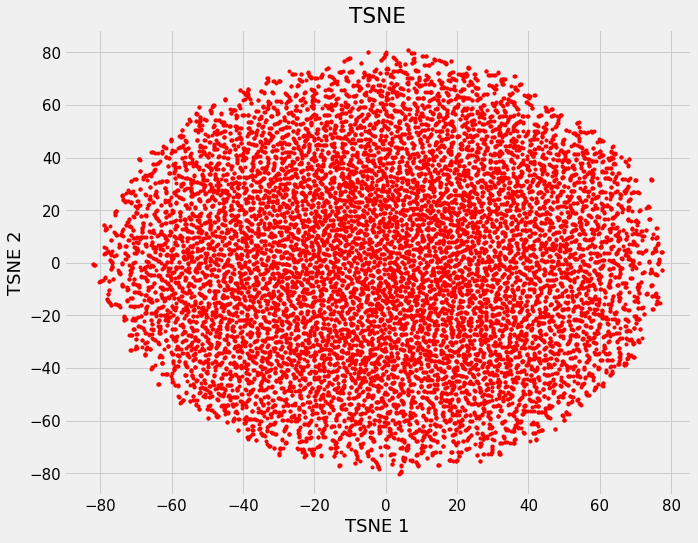

In [132]:
# InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(tsne[:, 0], tsne[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE');